# Step 0: Load The Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle
import os, re, sys
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
train_data = 'drive/MyDrive/traffic_sign/train.p'
val_data = 'drive/MyDrive/traffic_sign/valid.p'
test_data = 'drive/MyDrive/traffic_sign/test.p'

with open(train_data, mode='rb') as f:
    train = pickle.load(f)
with open(val_data, mode='rb') as f:
    valid = pickle.load(f)
with open(test_data, mode='rb') as f:
    test = pickle.load(f)

In [5]:
X_train, y_train = train['features'], train['labels']
X_val, y_val = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [6]:
print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)
print("Val shape: ", X_val.shape)

Train shape:  (34799, 32, 32, 3)
Test shape:  (12630, 32, 32, 3)
Val shape:  (4410, 32, 32, 3)


In [7]:
label ={}
with open('drive/MyDrive/traffic_sign/signnames.csv') as f1:
    line = csv.reader(f1)
    for l in line:
        label[int(l[0])] = l[1]

In [9]:
train = X_train.shape[0]
validation = X_valid.shape[0]
test = X_test.shape[0]
image_shape = X_train[0].shape

classes = len(set(list(y_train) + list(y_valid) + list(y_test)))

print("Number of training examples =", train)
print("Number of testing examples =", test)
print("Number of validation examples =", validation)
print("Image data shape =", image_shape)
print("Number of classes =",classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


# Step1: Dataset Summary & Exploration

## General numbers

## Image samples

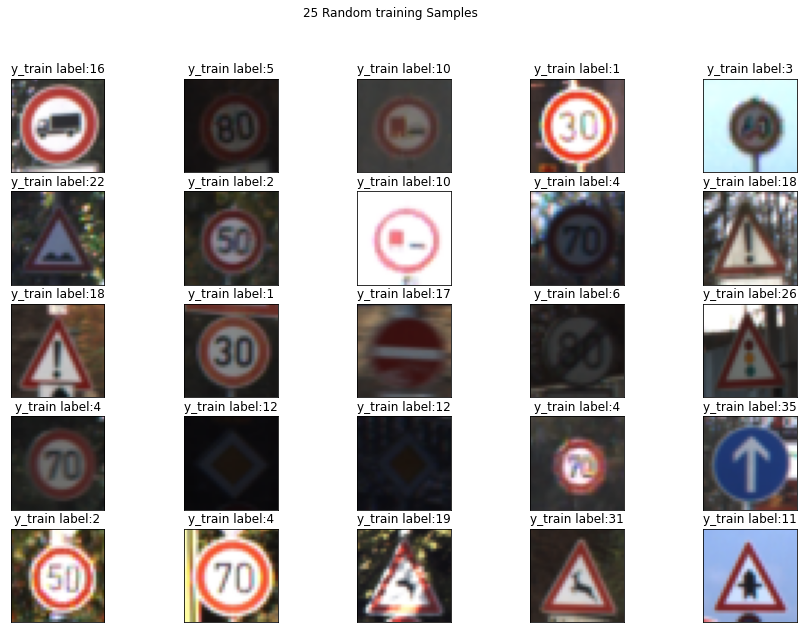

In [10]:
from numpy.random.mtrand import rand
# Plot dev samples

import seaborn as sns
import random
import random
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
fig.suptitle('25 Random training Samples')
rand_range = list(random.randint(0, len(X_train)) for r in range(25))
for i in rand_range:
    plt.subplot(5,5,rand_range.index(i)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.title("y_train label:" + str(y_train[i]))
plt.show() 

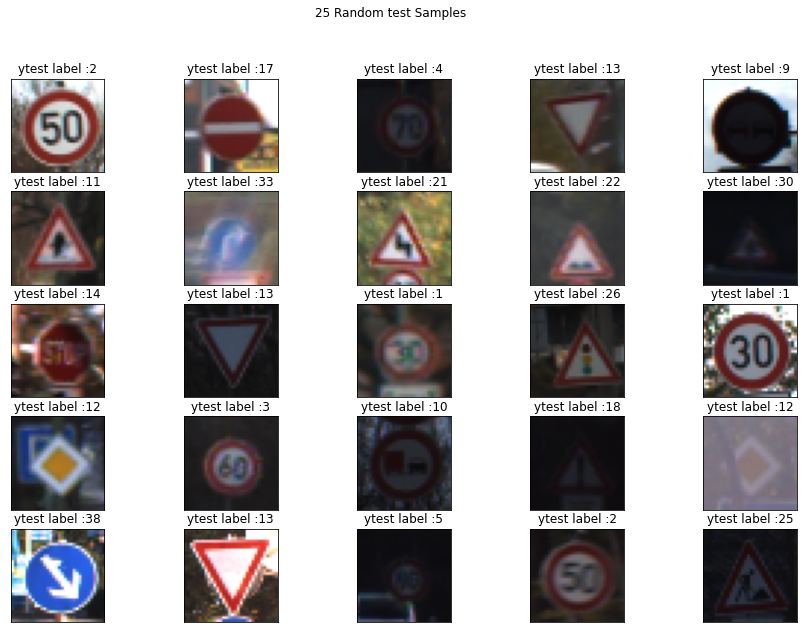

In [13]:
# Plot test samples

fig = plt.figure(figsize=(15,10))
fig.suptitle('25 Random test Samples')
rand_range_test = list(random.randint(0, len(X_test)) for r in range(25))
for i in rand_range_test:
    plt.subplot(5,5,rand_range_test.index(i)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    plt.title("ytest label :" + str(y_test[i]))
plt.show()

## Label distribution

[41 41 41 ... 25 25 25]
43


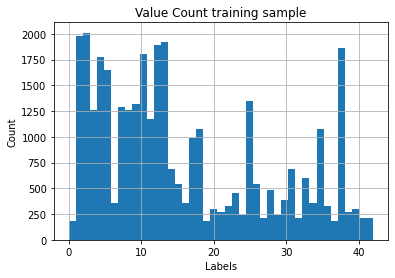

In [36]:
print(y_train)
print(classes)
plt.hist(y_train,classes)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title("Value Count training sample")
plt.grid(True)

## Train image generation (augmentation)

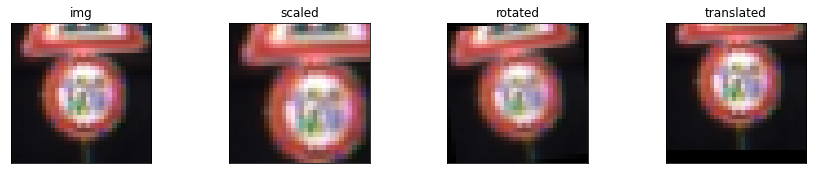

In [60]:
rand_idx = random.randint(0, len(X_train))
img = X_train[rand_idx]

x = random.uniform(1.0, 1.3)
y = random.uniform(1.0, 1.3)
scaled = cv2.resize(img,None,fx=x, fy=y, interpolation = cv2.INTER_CUBIC)[0:32, 0:32,:]
Y_translated = random.randint(-5, 5)
X_translated = random.randint(-5, 5)
translated = np.float32([[1,0,Y_translated],[0,1,X_translated]])
translated = cv2.warpAffine(img,translated,(32,32))
angle = random.randint(-90, 90)
rotated = cv2.getRotationMatrix2D((16,16),angle,1)
rotated = cv2.warpAffine(img,rotated,(32,32))

fig = plt.figure(figsize=(15,15))

final = [img,scaled,rotated,translated]
final_label = ["img","scaled","rotated","translated"]
for i in range(0,len(final)):
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(final[i])
    plt.title(str(final_label[i]))
plt.show()


## Pre-processing

In [61]:
def preprocessing(images):
    output = np.zeros((len(images), 32, 32, 3), np.float64)
    for index, img in enumerate(images):
        gray = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
        output[index] = (gray.astype(np.float64) - 128)/128
    return output

In [62]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)
X_train = preprocessing(X_train)
X_valid = preprocessing(X_valid)
X_test = preprocessing(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


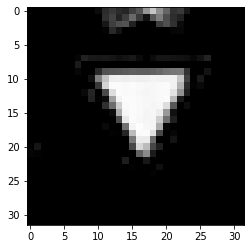

In [66]:
plt.imshow(X_train[500])

In [67]:
import tensorflow as tf

In [68]:
from tensorflow.keras.utils import to_categorical

y_valid = to_categorical(y_valid, 43)
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

In [69]:
model_lenet2eb = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, (5,5), padding='same', activation=tf.nn.relu,
                           input_shape=(32,32,3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(16, (5,5), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(120, (5,5), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(84, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(43, activation=tf.nn.softmax)
])

In [70]:
model_lenet2eb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 dropout (Dropout)           (None, 32, 32, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        2416      
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                    

In [71]:
model_lenet2eb.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])


In [72]:
model_lenet_metric = model_lenet2eb.fit(X_train, 
                                     y_train,
                                    batch_size=64,
                                    epochs=20,
                                    validation_data=(X_valid, y_valid))

Epoch 1/20
544/544 [==============================] - 17s 8ms/step - loss: 2.1912 - accuracy: 0.3902 - val_loss: 1.5702 - val_accuracy: 0.7245
Epoch 2/20
544/544 [==============================] - 3s 6ms/step - loss: 1.0999 - accuracy: 0.6571 - val_loss: 1.0479 - val_accuracy: 0.7991
Epoch 3/20
544/544 [==============================] - 3s 5ms/step - loss: 0.8572 - accuracy: 0.7313 - val_loss: 0.8137 - val_accuracy: 0.8392
Epoch 4/20
544/544 [==============================] - 3s 5ms/step - loss: 0.7340 - accuracy: 0.7676 - val_loss: 0.6836 - val_accuracy: 0.8687
Epoch 5/20
544/544 [==============================] - 3s 5ms/step - loss: 0.6515 - accuracy: 0.7931 - val_loss: 0.5641 - val_accuracy: 0.8841
Epoch 6/20
544/544 [==============================] - 3s 5ms/step - loss: 0.5810 - accuracy: 0.8126 - val_loss: 0.5496 - val_accuracy: 0.8803
Epoch 7/20
544/544 [==============================] - 3s 5ms/step - loss: 0.5348 - accuracy: 0.8289 - val_loss: 0.5094 - val_accuracy: 0.8923
Epoch

In [74]:
model = model_lenet2eb
model.save("drive/MyDrive/traffic_sign/train_sign.h5")

In [75]:
import pandas as pd

data = pd.DataFrame(model_lenet_metric.history)

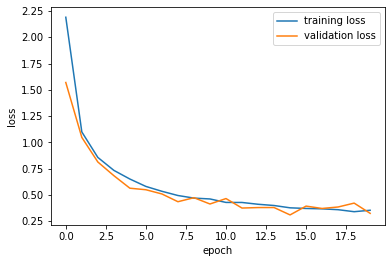

In [76]:
fig, ax = plt.subplots();
ax.plot(data.index, data['loss'], label='training loss');
ax.plot(data.index, data['val_loss'], label='validation loss');
ax.set_xlabel('epoch');
ax.set_ylabel('loss');
plt.legend()

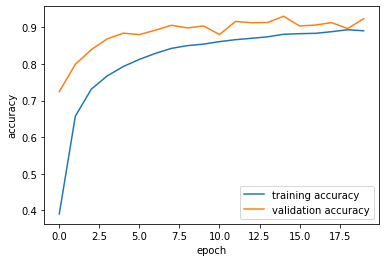

In [77]:
fig, ax = plt.subplots();
ax.plot(data.index, data['accuracy'], label='training accuracy');
ax.plot(data.index, data['val_accuracy'], label='validation accuracy');
ax.set_xlabel('epoch');
ax.set_ylabel('accuracy');
plt.legend()

## Model Architecture

## Load and Output the Images

In [78]:
import glob
import matplotlib.image as mpimg

In [81]:
test = 'drive/MyDrive/traffic_sign/test'
img = glob.glob('drive/MyDrive/traffic_sign/test/*.jpg')
test = [mpimg.imread('./' + i ) for i in img ]

In [84]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, y_test)
print("Accuracy on the trained model", score[1])

395/395 [==============================] - 2s 4ms/step - loss: 0.3212 - accuracy: 0.9131
Accuracy on the trained model 0.9130641222000122


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

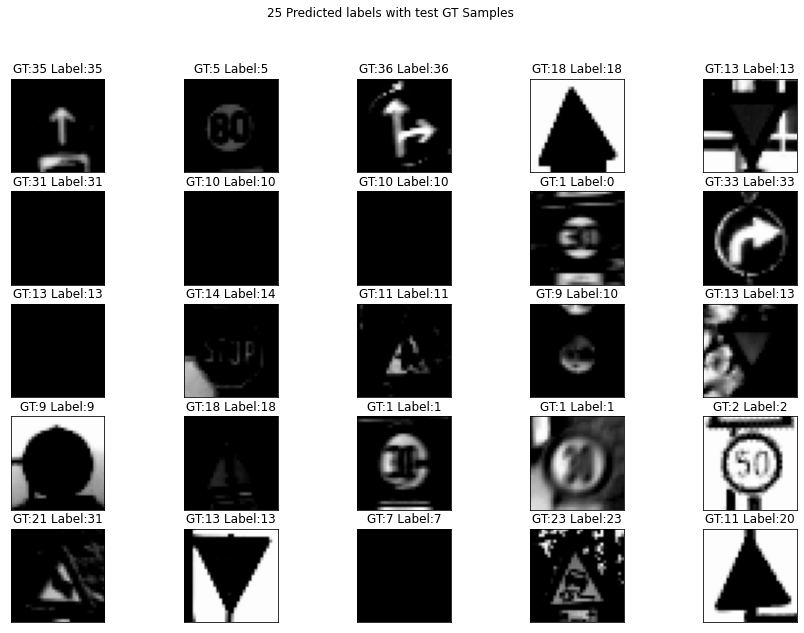

In [91]:
# Plot with predictions
fig = plt.figure(figsize=(15,10));
fig.suptitle('25 Predicted labels with test GT Samples')
rand_range_test_pred = list(random.randint(0, len(X_test)) for r in range(25))
for i in rand_range_test_pred:
    plt.subplot(5,5,rand_range_test_pred.index(i)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    plt.title("GT:" + str(np.argmax(y_test[i])) +" Label:" + str(np.argmax(predictions[i])))
plt.show();